In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import geopandas as gpd
import os
import sys
import numpy as np

data_destinations = '/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/data/destinations'
data_differences = '/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/data/differences'
data_social = '/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/data/social'

zipcode_file = pathlib.Path("/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/tl_2017_us_zcta510.zip")
# Check existence
if zipcode_file.exists():
    zipcode_gdf = gpd.read_file(f"zip://{zipcode_file}")
else:
    print("File not found! Make sure it's in the current directory.")

_types = ['age', 'household', 'family', 'nonfamily', 'married', 'race']
_upperbound = [18, 10, 10, 10, 10, 9]

In [8]:
def get_station_indexes(station, city):
    """
    Function to get the indexes of each station in a city. Each station has a zipcode and each zipcode has an index for each type.
    The function will return a dictionary with the indexes of each type.

    Args:
        - station: station name
        - city: city name
    """
    
    station_path = data_stations + city + '.csv'
    index_path = data_indexes + city + '.csv'
    
    # get the zipcode of the station in the station file
    station_df = pd.read_csv(station_path, encoding='cp1252', dtype={'zipcode': str})
    station_info = station_df[station_df['station'] == station]
    
    if station_info.isnull().values.any():
        return None
    
    zipcode = station_info['zipcode'].values[0]
    
    # get the indexes of the zipcode in the index file
    index_df = pd.read_csv(index_path, encoding='cp1252', dtype={'location': str})
    index_info = index_df[index_df['location'] == zipcode]
    
    if index_info.empty:
        return None
    
    indexes = dict()
    
    for type in _types:
        indexes[type] = index_info[type].values[0]
    
    return indexes

def get_zipcode_indexes(zipcode):
    """
    Function to get the indexes of a specific zipcode. Each zipcode has an index for each type.

    Args:
        zipcode (string): zipcode
    """
    index_path = data_indexes + city + '.csv'
    
    # get the indexes of the zipcode in the index file
    index_df = pd.read_csv(index_path, encoding='cp1252', dtype={'location': str})
    index_info = index_df[index_df['location'] == zipcode]
    
    indexes = dict()
    
    for type in _types:
        indexes[type] = index_info[type].values[0]
        
    print(indexes)
    
    return indexes

In [9]:
def plot_heatmap(df, city, zipcode):
    """
    Function to plot the heatmap of the social mixing index for the city's stations
    
    Input:
        - city: string with the city name
    """
    import seaborn as sns
    
    colors = sns.color_palette("viridis", as_cmap=True)
    
    # get the columns with the indexes
    indexes = df.columns[2:]
    
    # create a heatmap with the indexes
    annotation = False
    if zipcode:
        annotation = True
    sns.heatmap(df[indexes], cmap=colors, yticklabels=df['station'], annot=annotation, fmt=".2f", linewidths=.5, linecolor='black')
    plt.suptitle('Social Mixing Index for ' + city)
    if zipcode:
        plt.title('Zipcode: ' + df['zipcode'].iloc[0])
    plt.xlabel('Index Type')
    plt.ylabel('Station')
    plt.show()

def plot_zipcode_heatmap(df, city):
    """
    Function to plot the heatmap of the social mixing index for the city's stations
    
    Input:
        - city: string with the city name
    """
    import seaborn as sns
    
    colors = sns.color_palette("viridis", as_cmap=True)
    
    # get the columns with the indexes
    indexes = df.columns[1:]
    
    # create a heatmap with the indexes
    sns.heatmap(df[indexes], cmap=colors, yticklabels=df['zipcode'], annot=False, fmt=".2f", linewidths=.5, linecolor='black', vmin=0, vmax=1)
    plt.title('Social Mixing Index for ' + city)
    plt.xlabel('Index Type')
    plt.ylabel('Zipcode')
    plt.show()

def plot_heatmap_on_map(df, type, city):
    """
    Function to plot the heatmap of the social mixing index for the city's stations on a map

    Args:
        df (DataFrame): DataFrame with the indexes percentage (0-1)
        type (str): the type of index to plot
        city (str): the city name
    """
    
    zipcode_gdf = gpd.read_file(f"zip://{zipcode_file}")
    
    # df is the DataFrame with the indexes for each zipcode
    # zipcode_gdf is the GeoDataFrame with the zipcodes
    
    # merge the two DataFrames
    merged = zipcode_gdf.merge(df, left_on='ZCTA5CE10', right_on='zipcode')
    
    # create the map
    fig, ax = plt.subplots(1, 1)
    
    # plot the map
    merged.plot(column=type, ax=ax, legend=True, cmap='viridis', legend_kwds={'label': "Social Mixing Index"})
    
    # add the title
    plt.suptitle(f'Social Mixing Index for {city}')
    plt.title(f'Index Type: {type}')
    
    plt.show()
    
    # return the list of zipcodes
    return merged['ZCTA5CE10'].to_list()

In [10]:
def get_difference_stations(departure, arrival, city):
    """
    Function to get the difference between two stations
    
    Input:
        - departure: string with the departure station
        - arrival: string with the arrival station
        - city: string with the city name
    """
    
    departure_indexes = get_station_indexes(departure, city)
    arrival_indexes = get_station_indexes(arrival, city)
    
    if departure_indexes is None or arrival_indexes is None:
        return None
    
    difference = dict()
    
    for type in _types:
        difference[type] = departure_indexes[type] - arrival_indexes[type]
    
    return difference

def get_difference_zipcodes(departure, arrival, city):
    """
    Function to get the difference between two zipcodes
    
    Input:
        - departure: string with the departure zipcode
        - arrival: string with the arrival zipcdoe
        - city: string with the city name
    """
    
    departure_indexes = get_zipcode_indexes(departure, city)
    arrival_indexes = get_zipcode_indexes(arrival, city)
    
    difference = dict()
    
    for type in _types:
        difference[type] = departure_indexes[type] - arrival_indexes[type]
    
    return difference

def get_differences(city):
    
    path = os.path.join(data_differences, city) + '.csv'
    
    df = pd.read_csv(path, encoding='cp1252')
    
    df = df.dropna()
    
    # count how many times a certain index appears
    difference_indexes = {type : {} for type in _types}
    
    for index, row in df.iterrows():
        
        for type in _types:
            if row[type] not in difference_indexes[type]:
                difference_indexes[type][row[type]] = 0
            difference_indexes[type][row[type]] += row['counter']
            
    return difference_indexes

In [11]:
def get_zipcodes(city):
    """
    Function to get the zipcodes of a city
    
    Args:
        city (str): the city name
        
    Returns:
        zipcodes (list): list with the zipcodes of the city
    """
    
    path = os.path.join(data_social, city, '2022')
    zipcodes = []
    
    for zipcode in os.listdir(path):
        zipcodes.append(zipcode)
    
    return zipcodes

def types_percentage(row):
    """
    Function to get the percentage of values for each type

    Args:
        row (Series): the row with the indexes
    """
    
    # for each type get the corresponding upperbound
    for type, upperbound in zip(_types, _upperbound):
        row[type] = row[type] / np.log(upperbound)
    return row

def get_percentage_values(df):
    """
    Function to get the percentage of values for each type

    Args:
        df (DataFrame): the DataFrame with the indexes
    """
    
    df = df.apply(types_percentage, axis=1)
    return df

In [12]:
def get_mean_zipcode(city, zipcode):
    """
    Function to get the mean indexes for a certain zipcode

    Args:
        city (str): the city name
        zipcode (str): the zipcode to get the indexes
    """
    
    path = os.path.join(data_destinations, city) + '.csv'
    
    df = pd.read_csv(path, encoding='cp1252', dtype={'zipcode': str})
    
    df = df.dropna()
    df = df[df['zipcode'] == zipcode]
    
    return df

def get_mean_all_zipcodes(city):
    
    zipcodes = get_zipcodes(city)
    indexes = list()
    
    for zipcode in zipcodes:
        
        # get the stations of the zipcode
        df = get_mean_zipcode(city, zipcode)
        
        # choose a random station (the first one)
        if df.empty:
            continue
        line = df.iloc[0]
        
        # insert the indexes in the list
        indexes.append(line)
        
    new_df = pd.DataFrame(indexes)
    return new_df

def get_each_zipcode_mean(city):
    """
    Function to get the mean indexes for each zipcode

    Args:
        city (str): the city name

    Returns:
        new_df (DataFrame): the DataFrame with the mean indexes for each zipcode
    """
    
    zipcodes = get_zipcodes(city)
    indexes = list()
    
    for zipcode in zipcodes:
        
        # get the stations of the zipcode
        df = get_mean_zipcode(city, zipcode)
        
        # choose a random station (the first one)
        if df.empty:
            continue
        
        zipcode_means = {type: list() for type in _types}
        for index, row in df.iterrows():
            for type in _types:
                zipcode_means[type].append(row[type])
        
        # get the mean for each type
        mean = {type: np.mean(values) for type, values in zipcode_means.items()}
        
        line = {'zipcode': zipcode}
        for type, value in mean.items():
            line[type] = value
            
        # insert the indexes in the list
        indexes.append(line)
        
    new_df = pd.DataFrame(indexes)
    return new_df

   zipcode       age  household    family  nonfamily   married      race
0    02130  0.891442   0.922047  0.840774   0.946444  0.728342  0.651862
1    02108  0.877462   0.877202  0.735402   0.911656  0.643103  0.553286
2    02139  0.868919   0.898262  0.784207   0.932186  0.691979  0.626320
3    02199  0.870471   0.904439  0.797670   0.928377  0.690930  0.608385
4    02155  0.905135   0.890603  0.796774   0.930278  0.714395  0.571037
5    02163  0.850433   0.907431  0.794294   0.937094  0.715771  0.621165
6    02138  0.889628   0.895849  0.770891   0.937955  0.694935  0.607734
7    02109  0.883846   0.861158  0.717951   0.900421  0.628563  0.514636
8    02136  0.957313   0.947609  0.900341   0.956622  0.771046  0.675734
9    02131  0.930642   0.925638  0.858115   0.954365  0.733652  0.654015
10   01970  0.973362   0.964663  0.910356   0.971902  0.812364  0.509502
11   02445  0.859355   0.913469  0.804303   0.945610  0.717744  0.611536
12   02474  0.925697   0.868139  0.759006   0.92926

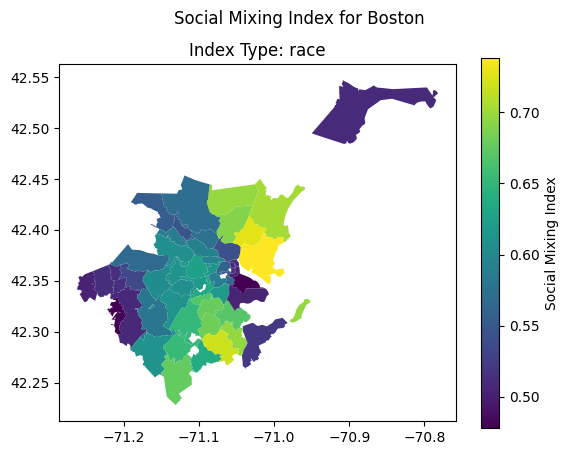

In [13]:
city = 'Boston'
is_zipcode = False
is_mean = True
is_type = True

if not is_mean:
    
    if len(sys.argv) > 2:
        zipcode = '02134'
        is_zipcode = True
    
    df = get_mean_zipcode(city, zipcode)
    df = get_mean_all_zipcodes(city)

    plot_heatmap(df, city, zipcode=is_zipcode)

else:
    df = get_each_zipcode_mean(city)
    df = get_percentage_values(df)
    print(df)
    
    if is_type:
        type = 'race'
        plot_heatmap_on_map(df, type, city)
    else:
        plot_zipcode_heatmap(df, city)